## Objective 
Q1 - Is vine reviews worth the investment - i.e., do vine reviewers share the same sentiment as the regular users ? 
Q2 - weed out bad vine reviewers.
Q2 - trends in books
Q3 - Recommender

In [47]:
import pandas as pd
import numpy as np
import random


import spacy
import nltk
from nltk.corpus import stopwords

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,HashingVectorizer

from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans, MiniBatchKMeans#, SpectralClustering, MeanShift, AgglomerativeClustering
from sklearn import metrics

from textblob import TextBlob
from yellowbrick.text import TSNEVisualizer
from yellowbrick.cluster import InterclusterDistance
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

## Data Importing and Setup / Categorization

In [2]:
df_chunk = pd.read_csv('data/processed/books.csv', iterator=False, chunksize=100000)

In [3]:
df_chunk.get_chunk()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,25933450,RJOVP071AVAJO,0439873800,84656342,There Was an Old Lady Who Swallowed a Shell!,Books,5,0,0,N,Y,Five Stars,I love it and so does my students!,2015-08-31
1,US,1801372,R1ORGBETCDW3AI,1623953553,729938122,I Saw a Friend,Books,5,0,0,N,Y,Please buy inchI Saw a Friendinch! Your childr...,My wife and I ordered 2 books and gave them as...,2015-08-31
2,US,5782091,R7TNRFQAOUTX5,142151981X,678139048,Black Lagoon Vol. 6,Books,5,0,0,N,Y,Shipped fast.,Great book just like all the others in the ser...,2015-08-31
3,US,32715830,R2GANXKDIFZ6OI,014241543X,712432151,If I Stay,Books,5,0,0,N,N,Five Stars,So beautiful,2015-08-31
4,US,14005703,R2NYB6C3R8LVN6,1604600527,800572372,Stars 'N Strips Forever,Books,5,2,2,N,Y,Five Stars,Enjoyed the author's story and his quilts are ...,2015-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,US,33390635,R12TDDYCSRSPF,150110571X,15052720,Clear by Fire: A Search and Destroy Thriller,Books,5,2,3,N,N,Renee Hart is the real thing,As a woman I wasn't sure that I would like thi...,2015-08-22
99996,US,48445068,R3KK49JDS7OWW6,0071493891,833590711,George Washington's Secret Navy: How the Ameri...,Books,4,0,0,N,Y,Four Stars,Interesting new insight into the revolution.,2015-08-22
99997,US,17905607,R13EJCHROI1RNR,1499106467,459722226,Child Support Kills: How To Avoid Becoming A C...,Books,5,0,0,N,Y,Very informative and well written! Kudos to th...,Very good info in this book and well written!,2015-08-22
99998,US,14397151,R383JSFRFF9L3T,0816529663,441316623,The Neolithic Revolution in the Near East: Tra...,Books,5,1,1,N,Y,An Excellent Resource,This was just what I was looking for. It provi...,2015-08-22


In [4]:
def chunk_preprocessing(chunk, cols):
    chunk = chunk[cols]
    return pd.DataFrame(chunk)

In [5]:
cols = ['review_id', 'review_date', 'review_body', 'product_parent', 'vine','verified_purchase', 'star_rating', 'customer_id', 'product_id']
df = chunk_preprocessing(df_chunk.get_chunk(), cols).set_index('review_id')
df = df[df.review_date != ''] # eliminating the reviews without a date.
display(df.shape)
df.head()

(100000, 8)

,review_date,review_body,product_parent,vine,verified_purchase,star_rating,customer_id,product_id
review_id,,,,,,,,
R23O92JDQCWS8N,2015-08-22,I've been playing the piano for about 30 years...,955351978,N,N,5,33492037,0793598788
R3GJHPLT45ZSLV,2015-08-22,SMALL - Great for back pack - very comprehensive,275786765,N,Y,5,42700515,0061992860
R2YWP3CYG5QDQ,2015-08-22,Be My Valentino by Sandra Dricker is book two ...,630101422,N,N,4,10918731,1426711611
R2C017D3ADTBII,2015-08-22,Very cool pictures perfect for the fashionist...,795669659,N,Y,5,29020717,0486499502
R1L2667KTPKDWN,2015-08-22,They are beautiful and sexy pictures. The guy...,968731632,N,Y,5,50201876,386787882X


## EDA

In [6]:
df.product_parent.nunique()

70451

In [7]:
def plot_dist (df):
    fig, ax = plt.subplots()
    plt.title('Distribution of ratings', fontsize=15)
    sns.countplot(df.star_rating)
    ax.set_ylabel('No. of Ratings(Millions)')
    plt.show()

In [8]:
def date_filter(df, start, end):
    mask = (df.timestamp > pd.to_datetime(start)) & (df.timestamp < pd.to_datetime(end))
    df = df[mask]
    return df

In [9]:
### Filtering_into_subgroups
def vine_reviewers_rating_filter(df, max_rate=5, min_rate=4, vine='Y'):
    df = df[df.vine == vine]
    df = df[(df.star_rating >= min_rate) & (df.star_rating <= max_rate)]
    return df

1. Are vine users a good representation of the regular user

A. compare 4-5star rated topics between regular user and vine user

B. compare 1-3 star rated topics between regular user and vine user

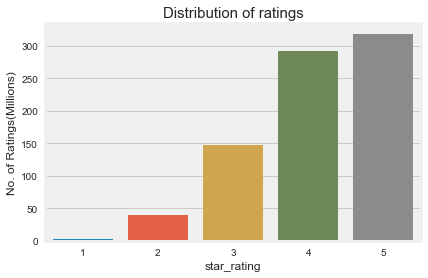

(800, 8)

In [10]:
all_vine_user = vine_reviewers_rating_filter(df, max_rate=5, min_rate=1, vine='Y')
plot_dist(all_vine_user)
all_vine_user.shape

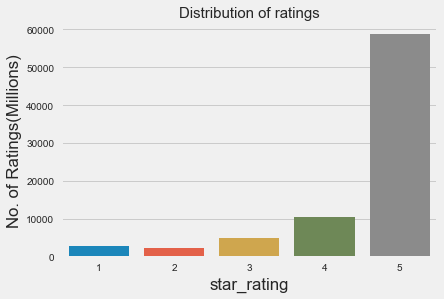

(79254, 8)

In [71]:
all_regular_user = vine_reviewers_rating_filter(df, max_rate=5, min_rate=1, vine='N')
all_regular_user = all_regular_user[all_regular_user.verified_purchase=='Y']
plot_dist(all_regular_user)
all_regular_user.star_rating.mean()
all_regular_user.shape

In [12]:
regular_user_low_rate = vine_reviewers_rating_filter(all_regular_user, max_rate=3, min_rate=1, vine='N')
display(regular_user_low_rate.shape)

(10143, 8)

In [13]:
regular_user_high_rate = vine_reviewers_rating_filter(all_regular_user, max_rate=5, min_rate=4, vine='N')
regular_user_high_rate.shape

(69111, 8)

In [14]:
vine_user_low_rate = vine_reviewers_rating_filter(all_vine_user, max_rate=3, min_rate=1, vine='Y')
vine_user_low_rate.shape

(189, 8)

In [15]:
vine_user_high_rate = vine_reviewers_rating_filter(all_vine_user, max_rate=5, min_rate=4, vine='Y')
vine_user_high_rate.shape

(611, 8)

In [16]:
all_vine_user.customer_id.nunique()

443

2. weed out the reviewer with a taste that doesnt match with the majority
vine user group by user - for each user 
identify 4-5 star rated topics and 1-3 star rated topics.

In [17]:
vine_user_count = all_vine_user.groupby(['customer_id'])['review_body'].count().reset_index(name='count')
vine_user_count = vine_user_count.sort_values('count', ascending=False)
vine_user_count = vine_user_count[vine_user_count['count']>=0]
#display(vine_user_count)
vine_user_id = list(vine_user_count['customer_id'].values)
display('Total number of vine reviewers', len(vine_user_id))
freq_vine_user_count = vine_user_count[vine_user_count['count']>=5]
display(freq_vine_user_count)
freq_vine_user_id = list(freq_vine_user_count['customer_id'].values)
display('Total number of frequent vine reviewers', len(freq_vine_user_id))


'Total number of vine reviewers'

443

,customer_id,count
101,33376665,26
214,46877221,22
293,51002365,11
60,21982343,8
277,50666371,8
85,30200955,8
155,39345823,8
402,52909137,8
2,11301320,7
43,17300922,7


'Total number of frequent vine reviewers'

27

In [18]:
# freq_vine_users_df = all_vine_user[all_vine_user.customer_id.isin(vine_user_id)]

# freq_vine_users_df_grouped = freq_vine_users_df.groupby(['customer_id'])['review_body'].count().reset_index(name='count')
# freq_vine_users_df_grouped = freq_vine_users_df_grouped.sort_values('count', ascending=False)
# freq_vine_users_df_grouped = freq_vine_users_df_grouped[freq_vine_users_df_grouped['count']>=5]
# len(freq_vine_users_df_grouped)


In [19]:
freq_vine_user_hr = freq_vine_users_df[freq_vine_users_df.star_rating>3]
freq_vine_user_hr_grouped = pd.DataFrame(freq_vine_user_hr.groupby(\
                    ['customer_id', 'star_rating','review_body'])\
                    ['star_rating'].count())
freq_vine_user_hr_grouped = freq_vine_user_hr_grouped.drop(columns=['star_rating'])

vine_user_hr_grouped.head()

NameError: name 'freq_vine_users_df' is not defined

In [ ]:
vine_user_lr = vine_users_df[vine_users_df.star_rating<4]
vine_user_lr_grouped = pd.DataFrame(vine_user_lr.groupby(['customer_id', 'star_rating','review_body'])\
                    ['star_rating'].count()).drop(columns=['star_rating'])


vine_user_lr_grouped.head()


In [20]:
most_reviewed_vine_cus = freq_vine_users_df[freq_vine_users_df.customer_id==46877221]
len(most_reviewed_vine_cus)
most_reviewed_vine_cus.iloc[0,:]

NameError: name 'freq_vine_users_df' is not defined

## Text Preprocessing

1. change product_title to review body
2. date separations monthwise

Plan
3. separate vine vs non-vine topics
4. text preprocessing - with spacy / nltk.

In [72]:
regular_users_corpus = pd.DataFrame(all_regular_user, columns=['review_body', 'star_rating'])
regular_users_corpus = regular_users_corpus.dropna()
len(regular_users_corpus)
regular_users_corpus.shape

(79248, 2)

### Test Cleaning

In [73]:
import regex as re
def text_cleaning(corpus):
    return re.sub(r'[^\w]\n', ' ', corpus)

In [74]:
for i in range(len(regular_users_corpus.review_body)):
    regular_users_corpus.review_body[i] = text_cleaning(regular_users_corpus.review_body[i])

/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Adding Stop Words

In [137]:
stop_words = stopwords.words('english')

In [138]:
sw_list1 = ['fascinating', 'enthralling', 'engrossing', 'nice', 
                        'people','youre', 'wa', 'book', 'good', 'buy', 'bought', 
                        'ok', 'better', 'best', 'help', 'little', 'br',
                        'br br', 'author', 'book br', 'ha', 'expected', 'wasn',
                        'okay', 'quite', 'story', 'really', 'didn', 'little',
                        'information', 'disappointed', 'read', 'interesting', 
                        'read book', 'hard', 'easy', 'page', 'cover', 'small',
                        'missing', 'quality', 'helpful', 'feel', 'description', 
                        'great', 'good', 'better', 'best','enjoy', 'boring', 
                        'poorly', 'he', 'awesome', 'bad', 'actually', 'words', 
                        'pages', 'thought', 'would', 'thing', 'well', 'written', 'read',
                        'reading', 'thinking', 'get', 'could', 'many', 'lot', 'amazing',
                        'also', 'books', 'perfect', 'way', 'make', 'us', 'highly', 'copy', 
                        'full', 'must', 'anyone', 'like', 'long', 'high', 'fast', 'wanted',
                        'text', 'came', 'use', 'liked', 'wonderful', 'excellent', 'wait', 
                       'beautiful', 'see', 'thank', 'thanks', 'thanked', 'needed', 'got',
                       'every', 'even', 'much', 'know', 'gave', 'give']
stop_words.extend(sw_list1)

#### POS - Adj / Adv removal

In [139]:
from spacy import displacy
from itertools import chain
import itertools

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def add_stop_words(doc):
    new_stop_words_ = []
    for t in doc:
            if (t.pos_ == 'ADJ') or (t.pos_ == 'ADV'):
                new_stop_words_.append(t)
    return list(set(new_stop_words_))

sw_list2 = []
for doc in nlp.pipe(regular_users_corpus.review_body):
    sw_list2 = itertools.chain(sw_list2, add_stop_words(doc))

In [140]:
for i in sw_list2:
    stop_words.append(i)

stop_words = list(set(stop_words))
len(stop_words)

446882

#### bigrams

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [ ]:
def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    trigram = gensim.models.Phrases(bigram[words], min_count = tri_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return bigram_mod, trigram_mod

In [ ]:
for doc in nlp.pipe(regular_users_corpus.review_body):
    words = list(sent_to_words(doc))

In [ ]:
words

In [ ]:
bigram_tr, trigram_tr = bigrams(words)

In [ ]:
bigram_tr

In [77]:
cv = CountVectorizer(stop_words=stop_words, min_df=0.01, max_df=0.8)
doc_word = cv.fit_transform(regular_users_corpus.review_body)
cv_corpus = pd.DataFrame(doc_word.toarray(), columns=cv.get_feature_names(), index=regular_users_corpus.index)
cv_corpus.shape


(79248, 175)

### Testing Spacy
#### Spacy to get parts of speech (pos_) and dependency (dep_)


#### Spacy nlp.pipe to process documents

In [ ]:
# %%time
# from spacy import displacy
# nlp = spacy.load('en_core_web_sm')

# def text_preprocess(text):
#     doc = nlp(text)
#     for t in doc:
#         if t.lower_ in ['awesome', 'super', 'excellent']:
#             if t.pos_ != 'NOUN' :
#                 if t.dep_ != 'amod':
#                     return True
#     return False

# #generator
# new_corpora = (i for i in corpus if text_preprocess(i))
# [next(new_corpora) for i in range (3)]

In [ ]:
# sentence = "The book was super interesting."
# displacy.render(nlp(sentence))
# #spacy.explain("acomp")

### Lemmatize and Stemming

In [134]:
stop_words = pd.read_csv('stop_words.csv')

In [89]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
snowball_stem = SnowballStemmer('english')
lancaster_stem = LancasterStemmer('english')

from nltk import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [90]:
def snowball(text):
    return ' '.join([snowball_stem.stem(word) for word in text.split(' ')])

def lancaster(text):
    return ' '.join([lancaster_stem.stem(word) for word in text.split(' ')])

def lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])

In [91]:
display(len(regular_users_corpus.review_body))
regular_users_corpus.head()

79248

,review_body,star_rating,lemmatized
review_id,,,
R3GJHPLT45ZSLV,SMALL - Great for back pack - very comprehensive,5,SMALL - Great for back pack - very comprehensive
R2C017D3ADTBII,Very cool pictures perfect for the fashionist...,5,Very cool picture perfect for the fashionista...
R1L2667KTPKDWN,They are beautiful and sexy pictures. The guy...,5,They are beautiful and sexy pictures. The guy...
RYDSPFN841JWR,Cute book to go with a great activity I do wit...,5,Cute book to go with a great activity I do wit...
R2LHNFS21BJQ2N,One of the best guide books in print for survi...,5,One of the best guide book in print for surviv...


In [ ]:
#regular_users_corpus['snowball'] = regular_users_corpus.review_body.apply(snowball)

In [93]:
#corpus['lancaster'] = corpus.review_body.apply(lancaster)

In [94]:
regular_users_corpus['lemmatized'] = regular_users_corpus.review_body.apply(lemmatize)

In [129]:
regular_users_corpus = regular_users_corpus.dropna()
regular_users_corpus.shape

(79248, 3)

### Countvectorizer and TFIDF

In [98]:
# tfidf_stemmed = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.8)
# X_tfidf_stemmed = tfidf_stemmed.fit_transform(regular_users_corpus.snowball)

# tfidf_stemmed_dtm = pd.DataFrame(X_tfidf_stemmed.toarray(), columns=tfidf_stemmed.get_feature_names(), index=regular_users_corpus.lemmatized.index)
# tfidf_stemmed_dtm.head()

In [141]:
tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
X_tfidf = tfidf.fit_transform(regular_users_corpus.lemmatized)

tfidf_dtm = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names(), index=regular_users_corpus.lemmatized.index)
tfidf_dtm.shape

(79248, 178)

In [142]:
cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
X_cv = cv.fit_transform(regular_users_corpus.lemmatized)

cv_dtm = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names(), index=regular_users_corpus.lemmatized.index)
cv_dtm.head()

,able,absolutely,almost,along,already,always,another,anything,around,arrived,...,word,work,world,worth,writer,writing,year,year old,yet,young
review_id,,,,,,,,,,,,,,,,,,,,,
R3GJHPLT45ZSLV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R2C017D3ADTBII,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1L2667KTPKDWN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RYDSPFN841JWR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R2LHNFS21BJQ2N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clustering

In [143]:
def cluster_plots(n_clusters, doc_word, vec, cat=False):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=5, random_state=5, verbose=False)
    km.fit(doc_word)
    print("Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(doc_word, km.labels_, sample_size=1000))
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = vec.get_feature_names()
    if cat == True:
        for i in range(n_clusters):
            print("Cluster %d:" % i)
            for j in order_centroids[i, :12]:
                print(' %s\n' % terms[j], end='')
        print()
    clust_plot = InterclusterDistance(km)
    clust_plot.fit(doc_word,km.labels_)

In [144]:
def find_optimal_clusters(data, min_k=2, max_k=16, delta_k=2):
    iters = range(min_k, max_k+1,delta_k)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, random_state=87,batch_size=1500,n_init=8).fit(data).inertia_)
        print(f'Fit {k} clusters')
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('no. clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('inertia')
    ax.set_title('inertia by no. clusters')

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters


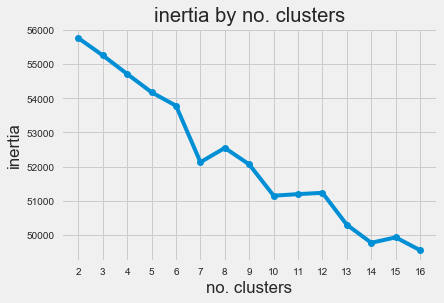

In [145]:
find_optimal_clusters(X_tfidf, min_k=2, max_k=16, delta_k=1)

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters


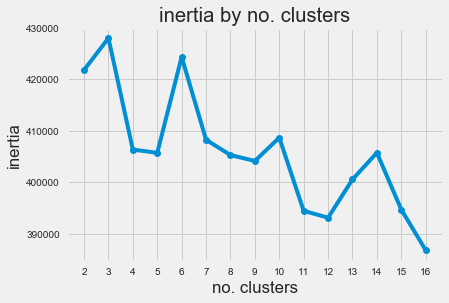

In [146]:
find_optimal_clusters(X_cv, min_k=2, max_k=16, delta_k=1)

Silhouette Coefficient: 0.491
Cluster 0:
 loved
 recommend
 time
 series
 new
 year
 gift
 fun
 condition
 enjoyed
 work
 old
Cluster 1:
 time
 life
 first
 year
 character
 work
 want
 new
 find
 think
 series
 recommend
Cluster 2:
 time
 work
 life
 world
 never
 may
 go
 say
 year
 doe
 want
 think
Cluster 3:
 time
 life
 character
 first
 work
 year
 new
 two
 world
 think
 series
 go



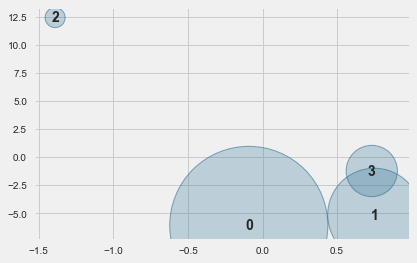

In [147]:
cluster_plots(4, X_cv, cv, cat=True)

Silhouette Coefficient: 0.372
Cluster 0:
 time
 life
 first
 character
 work
 want
 find
 series
 new
 think
 take
 recommend
Cluster 1:
 year
 old
 year old
 time
 first
 loved
 new
 recommend
 son
 daughter
 still
 child
Cluster 2:
 time
 life
 character
 first
 work
 new
 year
 two
 world
 series
 think
 go
Cluster 3:
 time
 life
 work
 world
 may
 year
 never
 go
 first
 say
 want
 doe
Cluster 4:
 loved
 recommend
 time
 series
 new
 condition
 gift
 fun
 work
 enjoyed
 life
 need



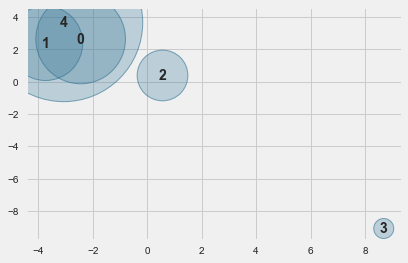

In [148]:
cluster_plots(5, X_cv, cv, cat=True)

Silhouette Coefficient: 0.337
Cluster 0:
 life
 character
 first
 work
 series
 want
 new
 find
 think
 world
 go
 reader
Cluster 1:
 year
 old
 year old
 time
 son
 daughter
 loved
 child
 recommend
 kid
 day
 first
Cluster 2:
 time
 life
 character
 first
 work
 new
 year
 two
 world
 think
 series
 say
Cluster 3:
 time
 work
 life
 world
 may
 never
 year
 go
 first
 say
 want
 still
Cluster 4:
 loved
 recommend
 series
 new
 gift
 condition
 fun
 work
 enjoyed
 first
 need
 want
Cluster 5:
 time
 first
 recommend
 work
 life
 take
 new
 year
 find
 want
 back
 think



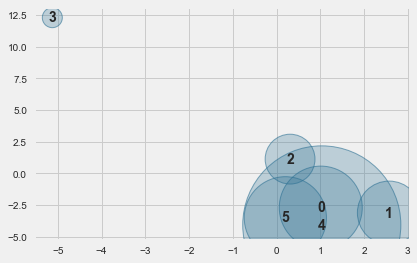

In [149]:
cluster_plots(6, X_cv, cv, cat=True)

Silhouette Coefficient: 0.163
Cluster 0:
 favorite
 time
 series
 year
 new
 far
 old
 daughter
 son
 child
 character
 ever
Cluster 1:
 condition
 arrived
 price
 received
 new
 happy
 described
 purchase
 time
 used
 exactly
 loved
Cluster 2:
 fun
 kid
 old
 time
 color
 year
 cute
 child
 loved
 year old
 picture
 series
Cluster 3:
 time
 loved
 life
 recommend
 series
 year
 new
 gift
 work
 first
 enjoyed
 old



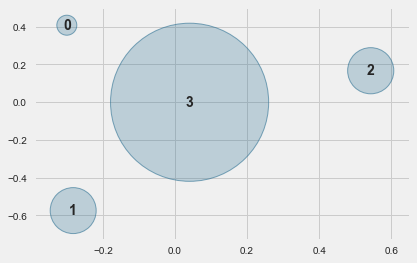

In [150]:
cluster_plots(4, X_tfidf, tfidf, cat=True)

Silhouette Coefficient: 0.141
Cluster 0:
 favorite
 time
 series
 far
 year
 old
 new
 daughter
 son
 ever
 child
 character
Cluster 1:
 condition
 arrived
 price
 received
 new
 happy
 described
 purchase
 time
 used
 exactly
 loved
Cluster 2:
 fun
 kid
 old
 color
 time
 year
 cute
 year old
 child
 loved
 series
 picture
Cluster 3:
 loved
 time
 life
 recommend
 series
 gift
 new
 year
 work
 enjoyed
 old
 need
Cluster 4:
 first
 time
 series
 character
 year
 second
 life
 two
 novel
 chapter
 new
 work



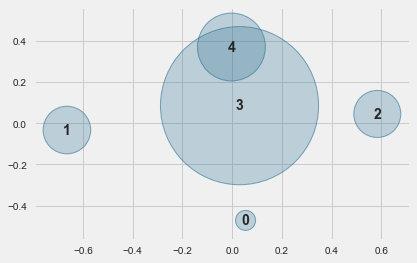

In [151]:
cluster_plots(5, X_tfidf, tfidf, cat=True)

Silhouette Coefficient: 0.140
Cluster 0:
 time
 life
 recommend
 condition
 new
 series
 year
 work
 gift
 enjoyed
 first
 need
Cluster 1:
 fun
 kid
 old
 color
 year
 time
 child
 year old
 loved
 enjoyed
 series
 recommend
Cluster 2:
 ever
 time
 life
 favorite
 first
 recommend
 year
 never
 work
 recipe
 everything
 far
Cluster 3:
 character
 series
 novel
 time
 life
 first
 reader
 end
 world
 writing
 enjoyed
 two
Cluster 4:
 cute
 old
 fun
 picture
 son
 daughter
 gift
 year old
 year
 loved
 time
 kid
Cluster 5:
 loved
 gift
 daughter
 son
 old
 series
 year
 kid
 year old
 friend
 put
 first



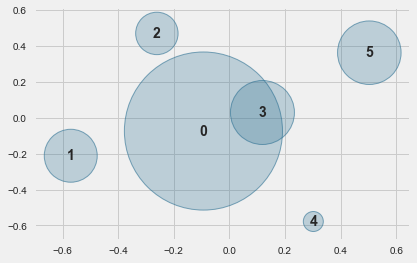

In [152]:
cluster_plots(6, X_tfidf, tfidf, cat=True)

## Topic Modeling

In [153]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### NMF

In [161]:
def nmf_test(X, vec, dim):
    
    nmf = NMF(dim, random_state=5)
    nmf_topic = nmf.fit_transform(X)
    nmf_word = pd.DataFrame(nmf.components_.round(2),
                           index=np.arange(1,dim+1),
                           columns=vec.get_feature_names())
    topics = nmf_word.transpose()
    for i, categories in enumerate(topics.columns):
        keywords = topics.loc[:,categories].sort_values(ascending=False).head(5)
        print(f'Topic {i}: {keywords.index.values}\n')
        
    return nmf, nmf_topic

In [162]:
nmf_5, topics_5 = nmf_test(X_tfidf, tfidf, 5)
len(topics_5)

Topic 0: ['time' 'life' 'year' 'recommend' 'new']

Topic 1: ['loved' 'daughter' 'son' 'kid' 'old']

Topic 2: ['condition' 'arrived' 'price' 'described' 'new']

Topic 3: ['series' 'character' 'enjoyed' 'next' 'whole']

Topic 4: ['gift' 'friend' 'daughter' 'purchased' 'happy']



79248

In [163]:
nmf_6, topics_6 = nmf_test(X_tfidf, tfidf, 6)
len(topics_6)

Topic 0: ['life' 'year' 'recommend' 'new' 'work']

Topic 1: ['loved' 'daughter' 'son' 'kid' 'old']

Topic 2: ['condition' 'arrived' 'price' 'described' 'new']

Topic 3: ['series' 'character' 'enjoyed' 'next' 'whole']

Topic 4: ['gift' 'friend' 'daughter' 'purchased' 'happy']

Topic 5: ['time' 'arrived' 'described' 'favorite' 'first']



79248

In [164]:
nmf_7, topics_7 = nmf_test(X_tfidf, tfidf, 7)
len(topics_7)

Topic 0: ['life' 'recommend' 'new' 'work' 'first']

Topic 1: ['loved' 'daughter' 'kid' 'son' 'put']

Topic 2: ['condition' 'arrived' 'price' 'described' 'new']

Topic 3: ['series' 'character' 'next' 'enjoyed' 'whole']

Topic 4: ['gift' 'friend' 'daughter' 'purchased' 'happy']

Topic 5: ['time' 'arrived' 'described' 'favorite' 'first']

Topic 6: ['year' 'old' 'year old' 'fun' 'daughter']



79248

In [165]:
nmf_cv_5, topics_cv_5 = nmf_test(X_cv, cv, 5)
len(topics_cv_5)

Topic 0: ['character' 'first' 'world' 'want' 'series']

Topic 1: ['god' 'work' 'bible' 'word' 'may']

Topic 2: ['life' 'woman' 'family' 'real' 'experience']

Topic 3: ['time' 'back' 'first' 'work' 'child']

Topic 4: ['year' 'old' 'year old' 'child' 'kid']



79248

In [166]:
nmf_cv_6, topics_cv_6 = nmf_test(X_cv, cv, 6)
len(topics_cv_6)

Topic 0: ['work' 'world' 'want' 'doe' 'say']

Topic 1: ['god' 'work' 'bible' 'word' 'man']

Topic 2: ['life' 'woman' 'family' 'real' 'novel']

Topic 3: ['time' 'first' 'back' 'take' 'still']

Topic 4: ['year' 'old' 'year old' 'loved' 'child']

Topic 5: ['character' 'series' 'novel' 'first' 'loved']



79248

In [167]:
nmf_cv_7, topics_cv_7 = nmf_test(X_cv, cv, 7)
len(topics_cv_7)

Topic 0: ['want' 'work' 'world' 'think' 'go']

Topic 1: ['god' 'work' 'bible' 'word' 'man']

Topic 2: ['life' 'family' 'woman' 'real' 'novel']

Topic 3: ['time' 'first' 'back' 'take' 'still']

Topic 4: ['year' 'old' 'year old' 'loved' 'child']

Topic 5: ['character' 'series' 'novel' 'first' 'loved']

Topic 6: ['history' 'chapter' 'world' 'first' 'show']



79248

In [ ]:
# Appears that 8 topics is ideal. for a TF-IDF max_df of 0.1

In [ ]:
nmf = NMF(8, random_state=5)
nmf_topic = nmf.fit_transform(X_tfidf)
nmf_topics_words = pd.DataFrame(nmf.components_.round(5), columns = tfidf.get_feature_names())
display_topics(nmf, tfidf.get_feature_names(), 10)

In [ ]:
nmf = NMF(8, random_state=5)
nmf_topic = nmf.fit_transform(X_cv)
nmf_topics_words = pd.DataFrame(nmf.components_.round(5),columns = cv.get_feature_names())
display_topics(nmf, cv.get_feature_names(), 10)

In [ ]:
nmf = NMF(8, random_state=5)
nmf_topic = nmf.fit_transform(X_tfidf_stemmed)
nmf_topics_words = pd.DataFrame(nmf.components_.round(5), columns = tfidf_stemmed.get_feature_names())
display_topics(nmf, tfidf_stemmed.get_feature_names(), 10)

In [ ]:
nmf_topic

In [173]:
topic_map = {
    0: 'Staying on top - Life, work, best-sellers',
    1: 'Bonding - Children, Family, and Leisure Reading',
    2: 'Value - Book Condition, Delivery, Value',
    3: 'Enjoyable - Leisure-Reading',
    4: 'Gift Purchase'
}

### LSA

In [168]:
lsa = TruncatedSVD(8, random_state=5)
lsa_topics = lsa.fit_transform(X_cv)
dtm_lsa = display_topics(lsa, cv.get_feature_names(), 5)


Topic  0
time, life, first, work, year

Topic  1
god, life, work, bible, word

Topic  2
work, history, year, chapter, god

Topic  3
series, character, work, god, new

Topic  4
year, old, year old, life, loved

Topic  5
god, series, year, old, year old

Topic  6
history, god, series, character, old

Topic  7
work, life, character, novel, year


In [169]:
lsa = TruncatedSVD(8, random_state=5)
lsa_topics = lsa.fit_transform(X_tfidf)
dtm_lsa = display_topics(lsa, cv.get_feature_names(), 5)


Topic  0
loved, time, life, series, year

Topic  1
loved, gift, daughter, son, kid

Topic  2
condition, arrived, price, described, product

Topic  3
series, enjoyed, condition, recommend, character

Topic  4
gift, year, old, year old, fun

Topic  5
gift, series, time, arrived, described

Topic  6
old, year, year old, fun, time

Topic  7
fun, recipe, daughter, recommend, cute


In [174]:
regular_users_corpus['NMF_topic'] = topics_5.argmax(axis=1)
regular_users_corpus['NMF_topic_name'] = regular_users_corpus.NMF_topic.map(topic_map)

In [175]:
regular_users_corpus.head()

,review_body,star_rating,lemmatized,NMF_topic,NMF_topic_name
review_id,,,,,
R3GJHPLT45ZSLV,SMALL - Great for back pack - very comprehensive,5,SMALL - Great for back pack - very comprehensive,0,"Staying on top - Life, work, best-sellers"
R2C017D3ADTBII,Very cool pictures perfect for the fashionist...,5,Very cool picture perfect for the fashionista...,0,"Staying on top - Life, work, best-sellers"
R1L2667KTPKDWN,They are beautiful and sexy pictures. The guy...,5,They are beautiful and sexy pictures. The guy...,0,"Staying on top - Life, work, best-sellers"
RYDSPFN841JWR,Cute book to go with a great activity I do wit...,5,Cute book to go with a great activity I do wit...,0,"Staying on top - Life, work, best-sellers"
R2LHNFS21BJQ2N,One of the best guide books in print for survi...,5,One of the best guide book in print for surviv...,0,"Staying on top - Life, work, best-sellers"


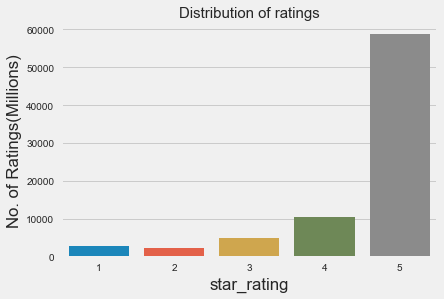

In [176]:
plot_dist(regular_users_corpus)


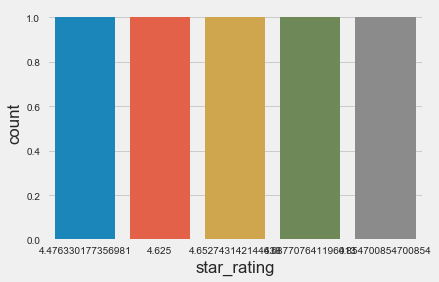

In [183]:
sns.countplot(regular_users_corpus.groupby('NMF_topic_name').star_rating.mean().sort_values())

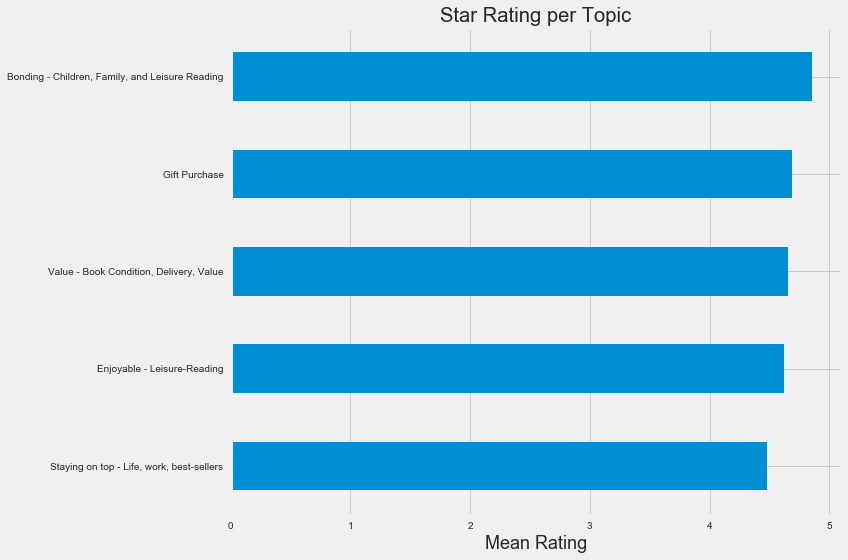

In [182]:
plt.figure(figsize=(12, 8))
topic_stars_grouped = regular_users_corpus.groupby('NMF_topic_name').star_rating.mean().sort_values()
# corpus.groupby('topic_name').claps.mean().sort_values().plot(kind='barh')
topic_stars_grouped.plot(kind='barh')
plt.xlabel('Mean Rating', size=18)
plt.ylabel('', size=18)
plt.title('Star Rating per Topic')
plt.tight_layout()
# plt.savefig('median_claps_topic.svg');

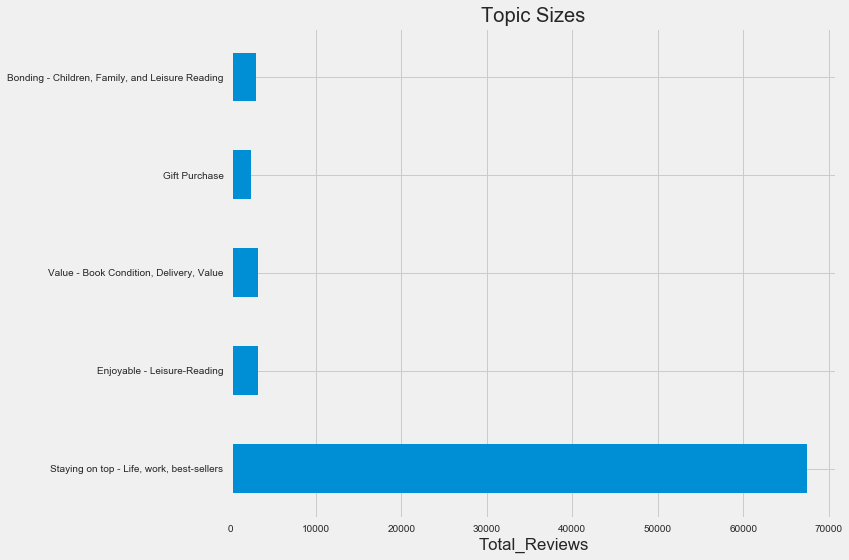

In [179]:
plt.figure(figsize=(12, 8))
regular_users_corpus.groupby('NMF_topic_name').NMF_topic.count()[topic_stars_grouped.index].plot(kind='barh')
plt.xlabel('Total_Reviews')
plt.ylabel('')
plt.title('Topic Sizes')
plt.tight_layout()
# plt.savefig('topic_sizes.svg');

In [ ]:
plt.figure(figsize=(14,12))
data = regular_users_corpus.groupby('NMF_topic_name').agg({'star_rating':'mean', 'NMF_topic':'count'}).sort_index()
data['name'] = data.index
sns.scatterplot(x='star_rating', y='NMF_topic', data=data, s=80)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), size=18)

label_point(data.star_rating, data.NMF_topic, data.name, plt.gca())

plt.xlabel('Mean Rating', size=18)
plt.ylabel('Total Reviews', size=18)
plt.tight_layout()
# plt.savefig('article_clap_scatter.svg');




## Visualization

In [ ]:
nmf_sc = StandardScaler().fit_transform(topics_8)
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=5)
nmf_pca = pca.fit_transform(nmf_sc)

In [ ]:
plt.figure(figsize=(20,16))
plt.scatter(nmf_pca[:,0], nmf_pca[:,1], c=nmf_sc.argmax(axis=1), cmap='jet', alpha=0.3)
plt.colorbar();

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, verbose=0)
data = model.fit_transform(nmf_sc)

In [ ]:
plt.figure(figsize=(15,12))
plt.scatter(data[:,0], data[:,1], c=regular_users_corpus.topic,cmap='jet', alpha=.5);

## LDA

In [ ]:
from gensim import corpora, models, similarities, matutils


In [ ]:
doc_word_cv = cv.transform(regular_users_corpus.review_body).transpose()
doc_word_tfidf = tfidf.transform(regular_users_corpus.review_body).transpose()

In [ ]:
corpus_cv = matutils.Sparse2Corpus(doc_word_cv)
corpus_tfidf = matutils.Sparse2Corpus(doc_word_tfidf)

In [ ]:
id2word_cv = dict((v, k) for k, v in cv.vocabulary_.items())
id2word_tfidf = dict((v, k) for k, v in tfidf.vocabulary_.items())

In [ ]:
len(id2word_cv)

In [ ]:
lda_cv = models.LdaModel(corpus=corpus_cv, num_topics=8, id2word=id2word, passes=5, random_state=5)
lda_tfidf = models.LdaModel(corpus=corpus_tfidf, num_topics=8, id2word=id2word, passes=5, random_state=5)

In [ ]:
lda_cv.print_topics()

In [ ]:
lda_tfidf.print_topics()

In [ ]:
lda_corpus = lda[corpus_]
lda_corpus

In [ ]:
lda_docs = [doc for doc in lda_corpus]

In [ ]:
lda_docs[0:5]

In [ ]:
topic_map = {
    0: 'Educational - Study Material',
    1: 'Self-Help / Recommended',
    2: 'Children Books',
    3: 'Series Books',
    4: 'Illustrative Books',
    5: 'Book Condition',
    6: 'for Gifting',
    7: 'Delivery time'
}

In [ ]:
regular_users_corpus['LDA_topic'] = lda_docs.argmax(axis=1)
regular_users_corpus['LDA_topic_name'] = regular_users_corpus.topic.map(topic_map)